SEAN FLETCHER

LAB 5

Machine Learning

F23


# Gradient Descent Lab

*  We implement our very own gradient descent algorithm to solve the task of predict median house values in Californian districts, given a number of features from these districts.
* In this notebook, we strip out a lot of the data investigation work. In addition, we only consider a small subset of the columns
* Read/run through the notebook and fund the exercises at the end


# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np

import os
import tarfile
import urllib.request

import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error


# Get the Data
   
   But first, few constant and f()s

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Download the Data

In [4]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_housing_data()

In [6]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [7]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Create a Test Set

In [8]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [9]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [11]:
len(test_set)

4128

# Discover and Visualize the Data to Gain Insights

## Lot's of graphs and geographical displays ... will skip for this lab

## Looking for Correlations ... will skip for this lab

## Experimenting with Attribute Combinations ... will skip for this lab

# Prepare the Data for Machine Learning Algorithms

## Data Cleaning ... minimal

In [12]:
housing_cols = ['housing_median_age', 'total_rooms', 'population', 'median_income']
housing_num = housing[housing_cols].fillna(housing[housing_cols].median())
housing_labels = housing['median_house_value']

## Transformation Pipelines

Now let's build a pipeline for preprocessing the numerical attributes:

In [13]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [14]:
housing_num_tr

array([[ 0.98214266, -0.8048191 , -0.9744286 ,  2.34476576],
       [-0.60701891,  2.0458901 ,  0.86143887,  2.33223796],
       [ 1.85618152, -0.53574589, -0.82077735,  1.7826994 ],
       ...,
       [-0.92485123, -0.17499526, -0.3695372 , -1.14259331],
       [-0.84539315, -0.35559977, -0.60442933, -1.05458292],
       [-1.00430931,  0.06840827, -0.03397701, -0.78012947]])

# Select and Train a Model

## Easy way : Training and Evaluating on the Training Set

In [15]:
sgd_reg = SGDRegressor(max_iter=10000, eta0=1e-3, tol=1e-3, random_state=42)
sgd_reg.fit(housing_num_tr, housing_labels)

SGDRegressor(eta0=0.001, max_iter=10000, random_state=42)

In [16]:
housing_predictions = sgd_reg.predict(housing_num_tr)
sgd_mse = mean_squared_error(housing_labels, housing_predictions)
sgd_rmse = np.sqrt(sgd_mse)
sgd_rmse


80211.74173521325

In [17]:
print(" theta values from SGD",sgd_reg.coef_)
print(" y intercept ", sgd_reg.intercept_)

 theta values from SGD [ 24889.63064788  20050.99333882 -12983.02624215  78419.00064077]
 y intercept  [206839.75946179]


In [18]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_num_tr, housing_labels)

LinearRegression()

In [19]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_num_tr)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

80211.61384149214

In [20]:
print(" theta values from Linear regression",sgd_reg.coef_)
print(" y intercept ", sgd_reg.intercept_)

 theta values from Linear regression [ 24889.63064788  20050.99333882 -12983.02624215  78419.00064077]
 y intercept  [206839.75946179]


## Manual SGD : Training and Evaluating on the Training Set

Sci-kit learn SGD and linear regression add a term for the y-intercept automatically, but we have to do it ourselves for the manual solution

In [21]:
housing_num_tr_b = np.c_[np.ones((housing_num_tr.shape[0], 1)), housing_num_tr] # add x0 = 1 to each instance

### Exercise : Cost Function

Implement the Mean squared error cost function for a linear regression (Pg 114 of the book).
As a challenge, I encourage you to form the matrix/vector form of the equation. For loop is okay though

In [22]:
# Define computeCost function
def computeCost(X, y, theta):
  no_of_rows = len(X)
  no_of_columns = len(X[0])
  no_of_rows_theta = len(theta)

  y_hat_bold = [0.0] * no_of_rows

  if no_of_columns == no_of_rows_theta:
        for i in range(no_of_columns):
          product_sum_by_row = 0.0
          for j in range(no_of_columns):
            the_value_in_the_matrix = X[i][j]
            theta_value = theta[j]
            value_product = the_value_in_the_matrix * theta_value
            product_sum_by_row += value_product

          y_hat_bold[i] = product_sum_by_row

  else:
    print("The matrix and vector dimensions are not compatible for dot product multiplication.")

  running_error = 0.0
  for k in range(len(y)):
    true_y = y[k]
    pred_y = y_hat_bold[k]
    the_error = true_y - pred_y
    the_squared_error = the_error**2
    running_error += the_squared_error

  the_mean_squared_error = running_error / len(y)

  return the_mean_squared_error


def computeCost02(X, y, theta):
    y_hat_bold = X @ theta

    squared_errors = (y - y_hat_bold) ** 2

    mse = np.mean(squared_errors)

    return mse

We test out our cost function for specific theta values

In [23]:
# Calculate computeCost with theta equal to zeros
theta = np.zeros(housing_num_tr_b.shape[1])

# print("pop")
# # print(housing_num_tr_b)
# print(len(housing_num_tr_b))
# print(len(housing_num_tr_b[0]))
# print("poop")
# # print(housing_labels)
# print(len(housing_labels))
# print(type(housing_labels))
# # print(len(housing_labels[0]))  # TypeError: object of type 'numpy.float64' has no len()
# print("pooop")
# print(theta)
# print(len(theta))

J1 = computeCost(housing_num_tr_b, housing_labels, theta)

print("With theta = %s, \nCost computed = %.2f " % (theta, J1))

#Answer Should be :
#    With theta = [0. 0. 0. 0. 0.],
#    Cost computed = 56104831989



With theta = [0. 0. 0. 0. 0.], 
Cost computed = 56104831989.87 


### Exercise : Batch Gradient Descent

Implement the batch gradient descent algorithm, save the cost at every iteration and return it along with
the improved theta value

In [24]:
#  Define the gradient descent algorithm and return cost history and theta
def gradientDescentMSE(X, y, theta, iterations, eta):
  improved_theta = theta
  J_hist = np.zeros([iterations])

  for epoch in range(iterations):
    y_hat_bold = X @ improved_theta
    the_error = y_hat_bold - y
    the_gradient = 2/len(y) * (X.T @ (the_error))
    improved_theta -= the_gradient * eta

    # J_hist[epoch] = computeCost02(X, y, improved_theta)    # I don't know why this line breaks the code.... but it does...

    cost = np.mean(the_error**2)
    J_hist[epoch] = cost

  return improved_theta, J_hist


Now run the batch gradient descent algorithm and check against my results

In [25]:
theta, J_hist = gradientDescentMSE(housing_num_tr_b, housing_labels, theta, iterations=5000,eta=1e-3)
print(theta)
print(J_hist)
J1 = computeCost02(housing_num_tr_b, housing_labels, theta)
J1

# With theta initialized to zero, I get 3221295137.061254 for the cost

[206846.51923791  24751.15638111  17557.15835239 -10630.36667451
  78982.79740158]
[5.61048320e+10 5.59070710e+10 5.57101012e+10 ... 6.43568886e+09
 6.43568800e+09 6.43568714e+09]


6435686288.119317

In [27]:
print(" theta values from Manual BGD",theta[1:4])
print(" y intercept ", theta[0])

 theta values from Manual BGD [ 24751.15638111  17557.15835239 -10630.36667451]
 y intercept  206846.519237907


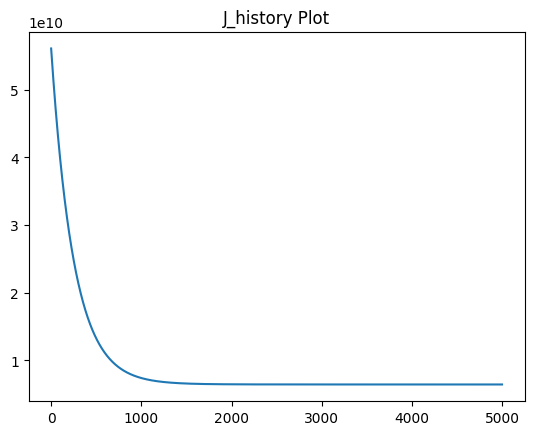

In [26]:
# Lets look at how the cost changes through iterations
plt.title("J_history Plot")
plt.plot(J_hist)

### Exercise : Compute the root mean squared error

Compare results to linear regression and Stochastic gradient descent. Why do you think the results are not quite as good as the scikit learn results ? (May want to look

I get 80265.74782634563 with theta initialized to zero, iterations=5000,eta=1e-3

In [28]:
"""
###
I don't know what you're asking me to do here.
Do you mean Computer the RMSE and then use that in the batch gradient descent implimentation?
When I look over the batch gradient descent implimentation I don't see how the cost function is used at all.
The gradient doesn't seem to take into account the cost function...
How would changing it from MSE to RMSE do anything different?
The only thing I see changing would be the returned J_hist... which doesn't actually affect the model?? Am I wrong here?

Also, above, I think you print out the the results from Stochastic twice and don't print out the results from linear regression.

"""

"\n###\nI don't know what you're asking me to do here. \nDo you mean Computer the RMSE and then use that in the batch gradient descent implimentation?\nWhen I look over the batch gradient descent implimentation I don't see how the cost function is used at all.\nThe gradient doesn't seem to take into account the cost function...\nHow would changing it from MSE to RMSE do anything different? \nThe only thing I see changing would be the returned J_hist... which doesn't actually affect the model?? Am I wrong here?\n\nAlso, above, I think you print out the the results from Stochastic twice and don't print out the results from linear regression.\n\n"

### Exercise : Hyperparameters

Change some of the hyperparameters (iterations or eta) to get an improved root mean squared (I was able to match scki-kit learn results of 80211)

In [29]:
"""
###
I've spent almost 5 hours on this lab so far. I don't have the time to do this.
"""

"\n###\nI've spent almost 5 hours on this lab so far. I don't have the time to do this.\n"

### Graduate students, Extra credit

Implement Stochastic gradient descent and compare the performance to batch gradient descent. Explain the results

In [49]:

import random

np.random.seed(13)
theta = np.random.rand(5, 1)

def learning_schedule(t, t0=5, t1=50):
    return t0 / (t + t1)

def stochastic_gradient_descent(X, y, theta, iterations, t0=5, t1=50):
    J_hist = np.zeros([iterations])

    for epoch in range(iterations):

        total_cost = 0.0

        for i in range(len(y)):

            # setting up the stochastic part of stochastic gradient descent
            random_index = random.randint(0, len(y) - 1)
            x_i = X[random_index : random_index +1]
            y_i = y[random_index: random_index + 1]

            # getting the error
            y_hat_bold = x_i @ theta

            ### this line is producing an error message, something about "data must be 1 dimensional"
            error = y_hat_bold - y_i

            gradient = 2 * x_i.T * error

            # eta is the learning rate
            eta = learning_schedule(epoch * len(y) + i)
            theta -= eta * gradient

            ### Calculate the cost (mean squared error) for the selected example
            ### I don't understand why scaling simplifies the derivative calculation...
            ### the quote below is from chat GPT...
            """
            (1 / 2) scales the squared error.
            This scaling is introduced because in the context of linear regression,
            the MSE formula often includes the factor of (1 / 2).
            This scaling doesn't affect the optimization process but simplifies the derivative calculation.
            """
            the_cost = (1 / 2) * error**2
            total_cost += the_cost

        # Calculate the average cost for the current epoch
        average_cost = total_cost / len(y)
        J_hist[epoch] = average_cost

    return theta, J_hist

In [ ]:
# print(len(housing_num_tr_b))
# print(len(housing_num_tr_b[0]))
# print(len(housing_labels))


a, b = stochastic_gradient_descent(housing_num_tr_b, housing_labels, theta, 50)

print(a)
print(b)

###
In total I spent around 6 hours on this lab. 7 hours if you include the time spent in class. I feel that I learned A LOT. Specifically I feel like I have a much more intuitive understanding aobut matrix multiplication, and because of that I think about the data I'm working with differently than I did before. That change in my thought process is invaluable.

This lab was also rather frustrating. There is a lot I don't understand. Like what a cost function is actually for... if it doesn't affect the gradient, and therefore it doesn't affect the changes in the model weights... then what is it used for? How does changing a cost function/cost metric change a model at all??

Implementing batch and stochastic was worth it because I can see how simple they both are, how those ideas are actually used/applied... but I wish I was able to get stochastic to actually run.



